# Pseudocode zur Implementierung

In [49]:
import pandas as pd
import numpy as np
import progressbar
import matplotlib.pyplot as plt
from IMPORT_DATAFRAME_JSON_HDF5 import *
%matplotlib notebook
import os
from IPython.display import display, HTML

In [50]:
# dieser Test-df wird von Christophs Programm erzeugt.
# wichtig!!! Bei der Besprechung müssen wir P_delta als NaN Value in den Datenframe einfügen

#Event dataframe anlegen zur späteren Auswertung der An/Abschaltevents
Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])

Leerlaufleistung_Phase = 0

## Funktion
-------

In [51]:
def add_p_delta(df):
    df_length = len(df)
    index_last_row = df_length - 1
    if(df_length > 1):
        p_new = df.iloc[index_last_row]['P']
        p_old = df.iloc[index_last_row-1]['P']
        p_delta = p_new - p_old
        return p_delta
    else:
        return 0

In [52]:
def detect_switch_event(rows, phase, Event_df):
    minuten_index = rows.index[-1]
    timestamp = rows.iloc[-1]['timestamp']
    Leerlaufleistung_Phase = dict[phase].iloc[0]['P']  
    ### Einschaltvorgang dedektieren ###
    # ist delta P relevant
    if(rows.iloc[-1]['P_delta'] > 200):
        # Prüfen ob Ladenvorgang beginnt/beendet
        # Wenn delta P positiv ---> event kreieren um später zu checken ob es ein Einschaltvorgang war
        Event_df.loc[len(Event_df)]= [timestamp, phase, minuten_index, 'ein', 'not checked', 0,0,0]
    
    #Check events: Überprüfen ob vorher eingetragenes event wirklich ein Einschaltvorgang ist
    event_df_length = len(Event_df)
    row_event = 0
    while row_event < event_df_length:
            #condition to check event
            minuten_index_event = Event_df.iloc[row_event]['minuten_index']
            #Check auf Einschaltvorgang
            if ((minuten_index_event+3 == minuten_index) & 
                (Event_df.iloc[row_event]['Ladevorgang'] == 'ein') &
                (Event_df.iloc[row_event]['Phase'] == phase)):
                Ladeleistung = rows.loc[minuten_index_event+3]['P'] - rows.loc[minuten_index_event-3]['P']            
                sum_delta_P = rows.loc[minuten_index_event:minuten_index_event+3]['P_delta'].sum()
                deviation = abs(Ladeleistung-sum_delta_P)/Ladeleistung 
                
                #print('deviation: {}'.format(deviation))
                #print('Ladeleistung: {}'.format(Ladeleistung))
                #print('minute: {}'.format(minuten_index_event))
                
                #Kein Einschaltvorgang:
                if ((deviation > 0.07) | (Ladeleistung < 1000)):
                    Event_df = Event_df.drop(row_event)
                    Event_df = Event_df.reset_index(drop=True)
                #Einschaltvorgang
                else:
                    #Mehrere Einschaltungen gleichzeitig
                    num_cars = Ladeleistung//3000
                    if (num_cars>=2):
                        Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', (Ladeleistung/num_cars)]
                        for num_cars in range (2,int(Ladeleistung//3000)+1):
                            Event_df.loc[row_event+1]= [timestamp, phase, minuten_index_event, 'ein', 'not checked', 0,0,0]
                            Event_df.loc[row_event+1, ['Status', 'Ladeleistung']] = ['checked', (Ladeleistung/num_cars)]
                            row_event += 1
                    #Ein Einschaltvorgang
                    else:
                        Event_df.loc[row_event, ['Status', 'Ladeleistung']] = ['checked', Ladeleistung]
            event_df_length = len(Event_df)
            row_event += 1
         
    ### Ausschaltvorgang dedektieren ###
    #Checken ob aktuelle Leistung das Ende eines Einschaltvorgangs impliziert 
    
    
    
    if (('ein' in Event_df['Ladevorgang'].unique()) &
        ('checked' in Event_df['Status'].unique())):
        # create df with charging status on
        only_load_event_df = Event_df[(Event_df['Ladevorgang'] == 'ein') &
                                      (Event_df['minuten_index'] < minuten_index)&
                                      (Event_df['Phase'] == phase)]
        # Soll Leistung = Leistung die auf der Phase anliegen sollte,
        # wenn alle zuvor ladenden Autos noch an der Phase hängen würden
        
        minuten_index_off = rows.index[-5]
        timestamp_off = rows.iloc[-5]['timestamp']
        
        Soll_Leistung = Leerlaufleistung_Phase + Event_df[(Event_df['Ladevorgang']=='ein') & 
                                                          (Event_df['minuten_index'] <= minuten_index) & 
                                                          (Event_df['minuten_index_Abschaltung'] == 0) & 
                                                          (Event_df['Phase'] == phase)]['Ladeleistung'].sum()
        #Aktuelle Leistung (neuer Messwert)
        Ist_Leistung = rows.iloc[-1]['P']
        #Residuale Leistung 
        P_residual = Soll_Leistung - Ist_Leistung
        #Überprüfen ob fehlende Leistung (P_residual) zu einem zuvor ladenden Auto passt
        only_load_event_df['deviation_P'] = only_load_event_df['Ladeleistung']. \
                                    apply(lambda ladeleistung_auto: abs(ladeleistung_auto-P_residual)/ladeleistung_auto)
        
        '''
        Morgen hier weiter machen. Vielleicht sollte ich den gradienten über die Leistung nehmen.
        Um neue Phasenanschlüsse kann ich dann zumbeispiel das herrausfinden wenn der Gradient stark positiv ist
        !!!Super wichtig für morgen!!!
        '''
        
        # create a np array from the last four P
        last_four_P = rows[-4:]['P'].values
        # calculate the gradient
        gradients_P = np.gradient(last_four_P)
        # calculate absolute gradients values
        abs_gradients_P = np.absolute(gradients_P)
        # calculate the absolute mean of the gradients
        abs_gradient_P = np.mean(abs_gradients_P)
        # calculate zhe mean of the gradients
        gradient_P = np.mean(gradients_P)
        
        if (((only_load_event_df['deviation_P'] < 0.2).any()) & ((abs_gradient_P < 5) | (gradient_P > 100))):
            # sort load events by size
            # und nehme das erste Event, was der aktuellen leistung am nächsten ist
            charg_off_ev_index = only_load_event_df['deviation_P'].sort_values().index[0]
            Event_df.loc[charg_off_ev_index,['minuten_index_Abschaltung']] = minuten_index_off
            Event_df.loc[charg_off_ev_index,['timestamp_abschalt']] = timestamp_off
            Event_df.loc[charg_off_ev_index, ['Ladevorgang']] = 'aus'
            
    return Event_df

In [53]:
def combine_charging_events(Event_df):
    # Zusammenfassen von mehrphasigen Ladevorängen
    for events in range(0,len(Event_df)):
        timestamp = Event_df.iloc[events]['timestamp']
        timestamp_abschaltung = Event_df.iloc[events]['timestamp_abschalt']
        Phase = []
        Ladeleistung = []
        same_events = Event_df.loc[Event_df['timestamp'] == Event_df.iloc[events]['timestamp']]
        event_count = len(same_events)
        for a in range (0,event_count):
            Phase.append(same_events.iloc[a]['Phase'])
            Ladeleistung.append(str(same_events.iloc[a]['Phase'])+': '+str(same_events.iloc[a]['Ladeleistung']))
        if (len(ladevorgang_df.loc[ladevorgang_df['timestamp_start'] == timestamp]) !=1):
            ladevorgang_df.loc[len(ladevorgang_df)]= [timestamp, Phase, Ladeleistung, timestamp_abschaltung]
            
    return ladevorgang_df

## Code Simulation auf dem Server
----
Hier kann der Code für eine Phase Simuliert werden

In [54]:
%%time

Event_df = pd.DataFrame(columns = ['timestamp','Phase','minuten_index',
                                   'Ladevorgang', 'Status', 'Ladeleistung',
                                   'minuten_index_Abschaltung','timestamp_abschalt'])
ladevorgang_df = pd.DataFrame(columns = ['timestamp_start','Phasen', 'Durchschnittliche Ladeleistung','Ladevorgang_ende'])



#Looping over dates
for filename in os.listdir('HDF5'):
    if (filename[6:7]=='1'):
        date = filename[-13:-3]
    else:
        continue
    P_Phase_1 = pd.read_hdf('HDF5/phase_1_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5',columns =['P', 'timestamps'])
    P_Phase_3 = pd.read_hdf('HDF5/phase_3_' + date + '.h5',columns =['P', 'timestamps'])
    dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
    P_Phase_1 = P_Phase_1[['P','timestamp']]
    P_Phase_2 = P_Phase_2[['P','timestamp']]
    P_Phase_3 = P_Phase_3[['P','timestamp']]
    
    P_Phase_1['P_delta'] = 0
    P_Phase_2['P_delta'] = 0
    P_Phase_3['P_delta'] = 0
    
    P_Phase_1= P_Phase_1.groupby(np.arange(len(P_Phase_1))//300).mean()
    P_Phase_2= P_Phase_2.groupby(np.arange(len(P_Phase_2))//300).mean()
    P_Phase_3= P_Phase_3.groupby(np.arange(len(P_Phase_3))//300).mean()

    pseudocode_df_1 = pd.DataFrame([])
    pseudocode_df_2 = pd.DataFrame([])
    pseudocode_df_3 = pd.DataFrame([])
    phasen_variable = 1


    for row in range(0, len(P_Phase_1)):
        #Phase 1
        
        pseudocode_df_1 = pseudocode_df_1.append(P_Phase_1[row:row+1])

        # call the function to add P-delta
        pseudocode_df_1.iloc[-1, pseudocode_df_1.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_1[-2:])

        # Detect all switch events
        Event_df = detect_switch_event(pseudocode_df_1.iloc[-7:], 1, Event_df)

        # Phase 2
        pseudocode_df_2 = pseudocode_df_2.append(P_Phase_2[row:row+1])
        pseudocode_df_2.iloc[-1, pseudocode_df_2.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_2[-2:])
        Event_df = detect_switch_event(pseudocode_df_2.iloc[-7:], 2, Event_df)

        # Phase 3
        pseudocode_df_3 = pseudocode_df_3.append(P_Phase_3[row:row+1])
        pseudocode_df_3.iloc[-1, pseudocode_df_3.columns.get_loc('P_delta')] = add_p_delta(pseudocode_df_3[-2:])
        Event_df = detect_switch_event(pseudocode_df_3.iloc[-7:], 3, Event_df)
    
    

/Users/markus/anaconda/envs/ev_project/lib/python3.5/site-packages/ipykernel/__main__.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/markus/anaconda/envs/ev_project/lib/python3.5/site-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/markus/anaconda/envs/ev_project/lib/python3.5/site-packages/ipykernel/__main__.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

CPU times: user 1min 11s, sys: 380 ms, total: 1min 11s
Wall time: 1min 11s


In [55]:
Event_df[Event_df['Phase']==3]

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
4,1.505810e+09,3,636,aus,checked,3590.06,931,1.50583e+09
11,1.505831e+09,3,987,aus,checked,3851.82,1014,1.50583e+09


In [56]:
Event_df

,timestamp,Phase,minuten_index,Ladevorgang,Status,Ladeleistung,minuten_index_Abschaltung,timestamp_abschalt
0,1.505793e+09,2,352,aus,checked,3441.23,465,1.5058e+09
1,1.505798e+09,1,426,aus,checked,3572.11,526,1.5058e+09
2,1.505800e+09,1,460,aus,checked,3583.57,549,1.5058e+09
3,1.505807e+09,2,577,aus,checked,3534.85,814,1.50582e+09
4,1.505810e+09,3,636,aus,checked,3590.06,931,1.50583e+09
5,1.505815e+09,2,719,aus,checked,3586.34,834,1.50582e+09
6,1.505821e+09,2,821,aus,checked,3458.28,1207,1.50584e+09
7,1.505824e+09,1,872,aus,checked,3605.48,937,1.50583e+09
8,1.505827e+09,2,919,aus,checked,3481.6,1014,1.50583e+09
9,1.505831e+09,1,987,aus,checked,3836.75,1017,1.50583e+09


In [57]:
combine_charging_events(Event_df)

,timestamp_start,Phasen,Durchschnittliche Ladeleistung,Ladevorgang_ende
0,1.505793e+09,[2],[2: 3441.22518921],1.505800e+09
1,1.505798e+09,[1],[1: 3572.1098938],1.505804e+09
2,1.505800e+09,[1],[1: 3583.56616211],1.505805e+09
3,1.505807e+09,[2],[2: 3534.85225677],1.505821e+09
4,1.505810e+09,[3],[3: 3590.0629425],1.505828e+09
5,1.505815e+09,[2],[2: 3586.33911133],1.505822e+09
6,1.505821e+09,[2],[2: 3458.27929688],1.505844e+09
7,1.505824e+09,[1],[1: 3605.47781372],1.505828e+09
8,1.505827e+09,[2],[2: 3481.59814453],1.505833e+09
9,1.505831e+09,"[1, 2, 3]","[1: 3836.74986267, 2: 3832.10693359, 3: 3851.8...",1.505833e+09


<IPython.core.display.Javascript object>


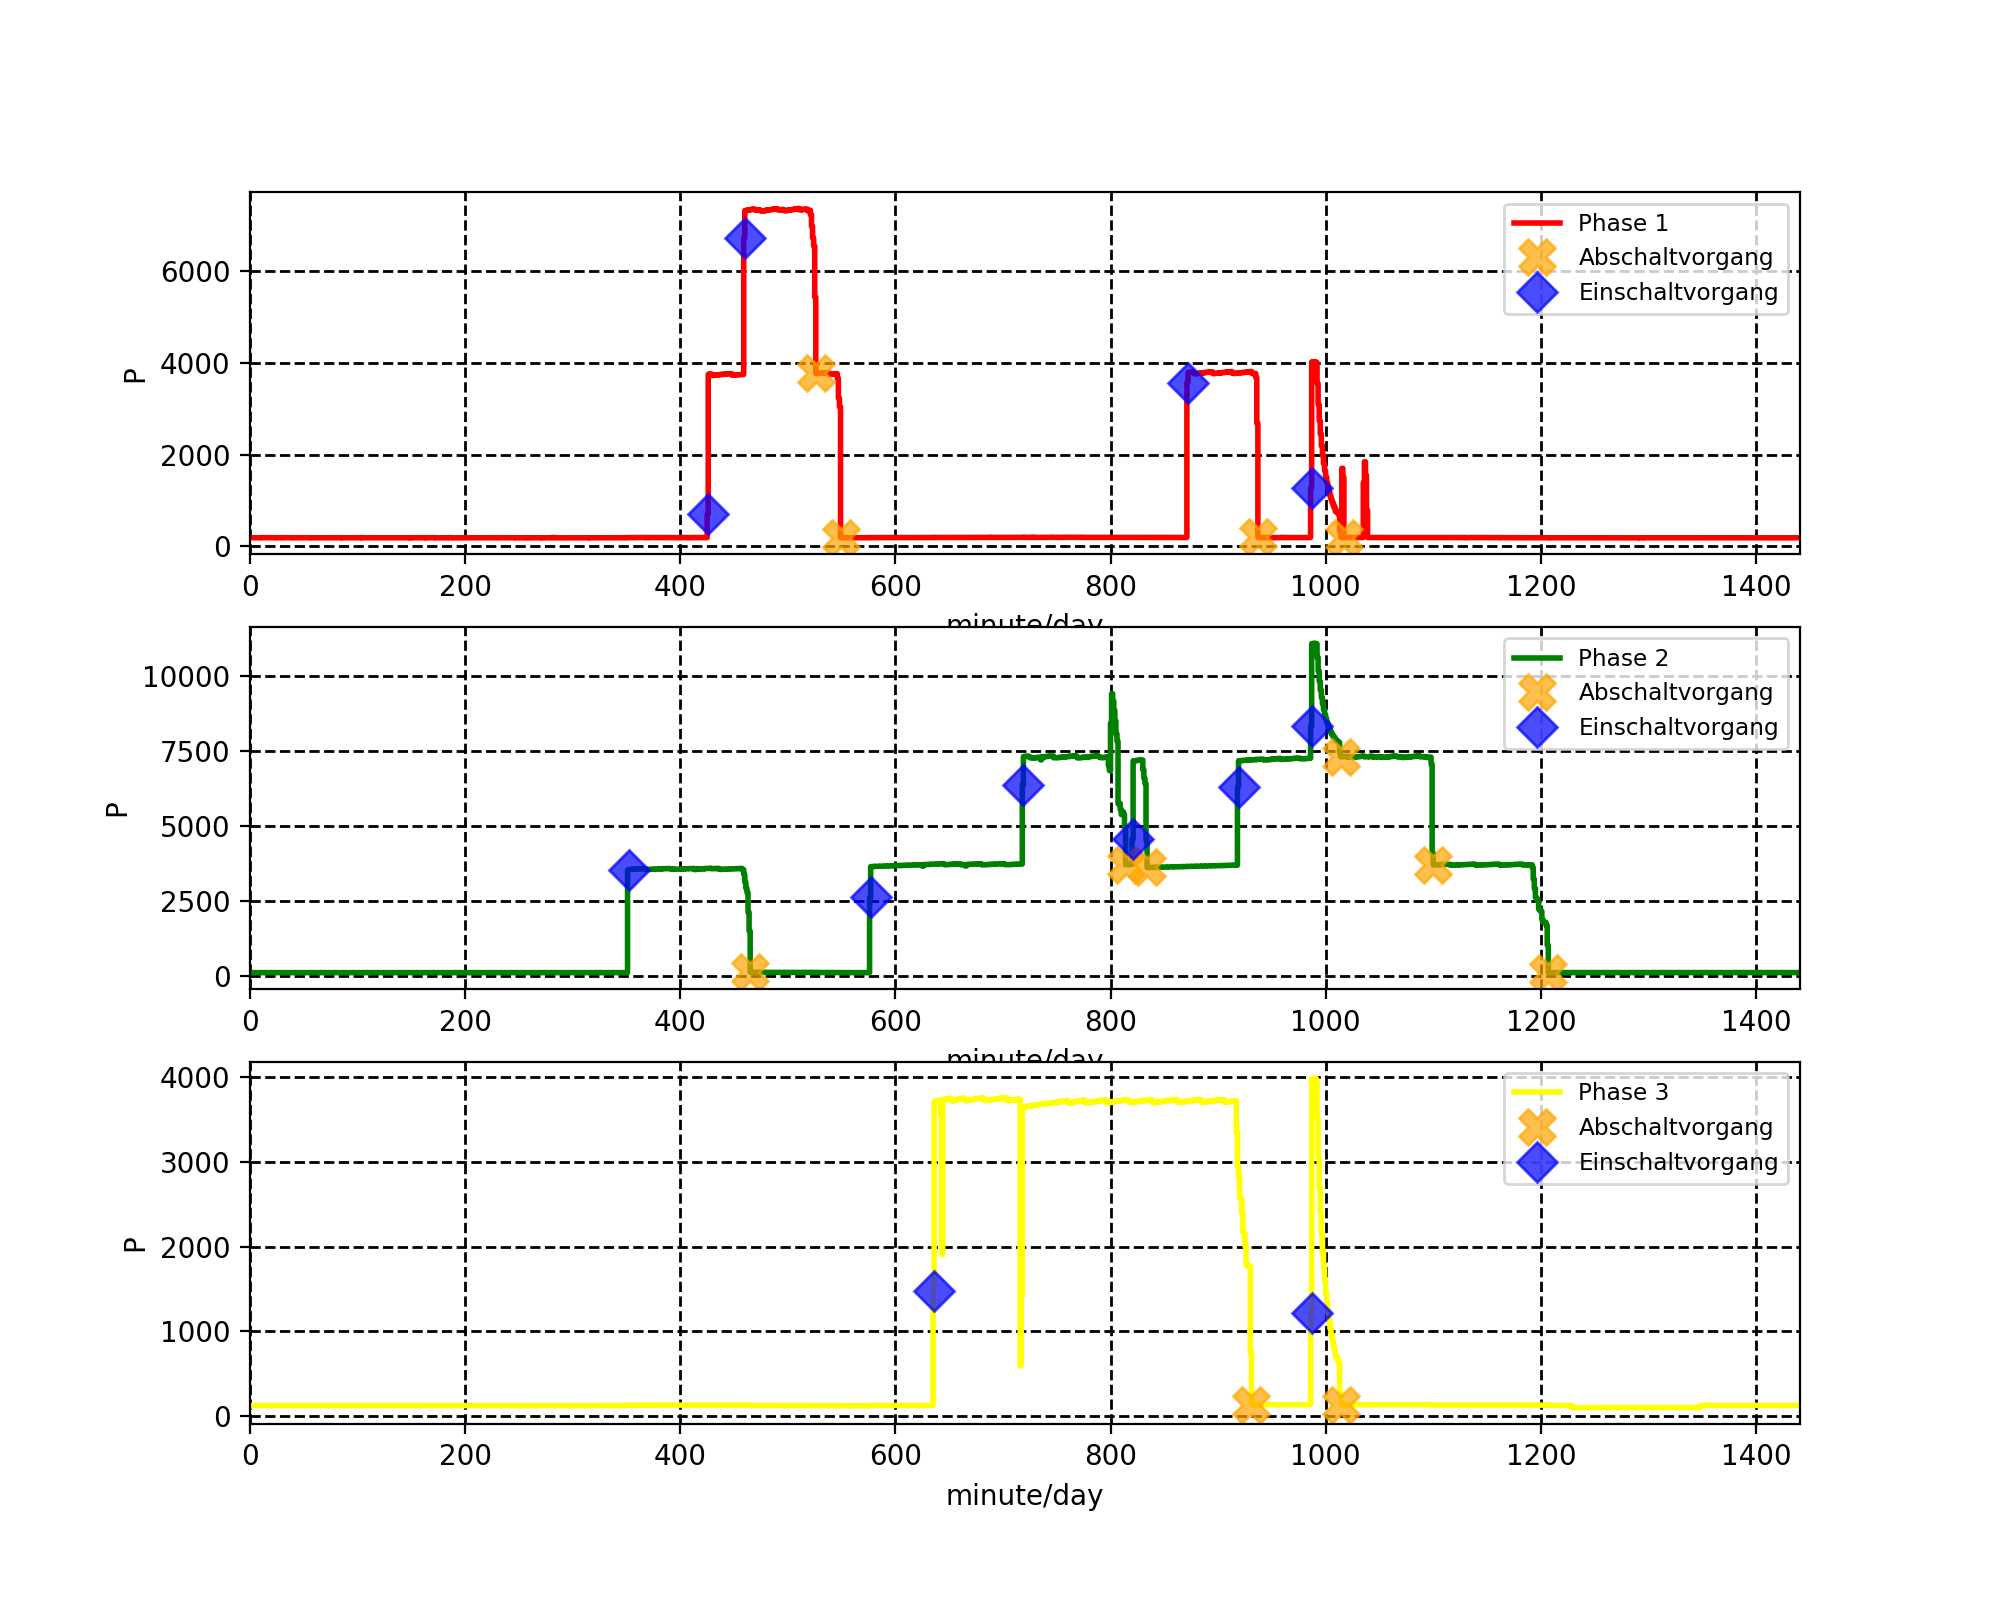

In [58]:
colors_phase = ['red','green','yellow']
#P_Phase_2 = pd.read_hdf('HDF5/phase_2_' + date + '.h5',columns =['P', 'timestamps'])
#P_Phase_2= P_Phase_2.groupby(np.arange(len(P_Phase_2))//300).mean()
dict = {1:P_Phase_1,2:P_Phase_2,3:P_Phase_3}
plt.figure(figsize=(10,8))
for Phase in range (1,4):
    Phase_P = dict[Phase]
    plt.subplot(310+Phase)
    plt.step(Phase_P.index,Phase_P['P'], color=colors_phase[Phase-1], linewidth=2, label='Phase '+str(Phase))
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index_Abschaltung']+1]['P'], "X",color="orange", markersize=13,alpha=.7, label='Abschaltvorgang')
    plt.plot(Event_df[Event_df.Phase == Phase]['minuten_index'], Phase_P.iloc[Event_df[Event_df.Phase == Phase]['minuten_index']]['P'], "D", color="blue", markersize=10,alpha=.7, label='Einschaltvorgang')
    plt.legend(loc='upper right', frameon=True, fontsize = 'small')
    plt.grid(color='k', linestyle='--', linewidth=1)
    plt.xlim([0,len(Phase_P)])
    plt.ylabel('P')
    plt.xlabel('minute/day')